# Fashion MNIST — Compare ANN vs CNN



This cell imports the necessary libraries for building and evaluating neural networks, including TensorFlow, NumPy, Matplotlib for plotting, and Seaborn for enhanced visualizations. It also prints the TensorFlow version to confirm the environment setup.

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


This cell loads the Fashion MNIST dataset, a standard benchmark for image classification. It then preprocesses the data by normalizing pixel values to a [0,1] range and reshapes the images for use with both CNNs (adding a channel dimension) and ANNs (flattening the images). Finally, it splits the training data into training and validation sets and prints the shapes of the resulting datasets.

Uncomment the second part of the code if loading the dataset from the drive.

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
from tensorflow.keras.datasets import fashion_mnist
import gzip
import struct
import numpy as np

# --- Option 1: Load data from Keras datasets (default) ---
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# --- Option 2: Load data from Google Drive (uncomment this section to use) ---
# def read_idx(filename):
#     """Reads idx files (MNIST/Fashion MNIST format)"""
#     with gzip.open(filename, 'rb') as f:
#         zero, data_type, dims = struct.unpack('>HBB', f.read(4))
#         shape = tuple(struct.unpack('>' + 'I' * dims, f.read(4 * dims)))
#         return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# # # Define paths to the dataset files in your Google Drive
# train_images_path = '/content/drive/MyDrive/fashion/train-images-idx3-ubyte.gz'
# train_labels_path = '/content/drive/MyDrive/fashion/train-labels-idx1-ubyte.gz'
# test_images_path = '/content/drive/MyDrive/fashion/t10k-images-idx3-ubyte.gz'
# test_labels_path = '/content/drive/MyDrive/fashion/t10k-labels-idx1-ubyte.gz'

# try:
#     train_images = read_idx(train_images_path)
#     train_labels = read_idx(train_labels_path)
#     test_images = read_idx(test_images_path)
#     test_labels = read_idx(test_labels_path)
#     print("Dataset loaded successfully from Google Drive.")
# except FileNotFoundError:
#     print("Error: Fashion MNIST files not found in the specified Google Drive path.")
#     print("Please make sure the paths are correct or use the default Keras download.")
#     # Fallback to Keras download if files not found in Drive
#     print("Falling back to downloading from Keras datasets...")
#     (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


# Normalize to [0,1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Reshape for CNN later
train_images_cnn = np.expand_dims(train_images, -1)  # (N,28,28,1)
test_images_cnn = np.expand_dims(test_images, -1)

# For ANN flatten images later

# Create a validation split from training
from sklearn.model_selection import train_test_split
train_images_cnn, validation_images_cnn, train_labels, validation_labels = train_test_split(train_images_cnn, train_labels, test_size=0.1, random_state=42, stratify=train_labels)
# Also keep flattened versions
train_images_ann = train_images_cnn.reshape((train_images_cnn.shape[0], -1))
validation_images_ann = validation_images_cnn.reshape((validation_images_cnn.shape[0], -1))
test_images_ann = test_images_cnn.reshape((test_images_cnn.shape[0], -1))

print('Train shape (CNN):', train_images_cnn.shape)
print('Val shape (CNN):', validation_images_cnn.shape)
print('Test shape (CNN):', test_images_cnn.shape)
print('Train shape (ANN flattened):', train_images_ann.shape)

# Class names for plotting
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

Train shape (CNN): (54000, 28, 28, 1)
Val shape (CNN): (6000, 28, 28, 1)
Test shape (CNN): (10000, 28, 28, 1)
Train shape (ANN flattened): (54000, 784)


This cell displays the first 10 images from the training dataset along with their corresponding class labels. This helps visualize the data and understand the types of images the models will be trained on.

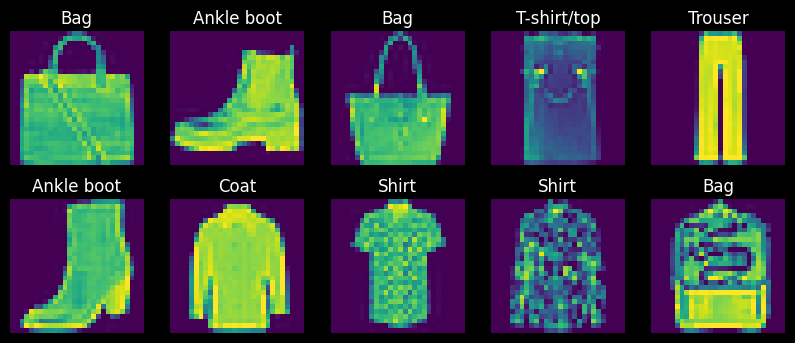

In [27]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_images_cnn[i].squeeze())
    plt.title(class_names[train_labels[i]])
    plt.axis('off')
plt.show()

In [28]:
from tensorflow.keras import layers

# Define the augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# We will apply this augmentation directly in the CNN model later.
# For visualization, we can apply it to a batch of training data.

This cell visualizes the effect of the data augmentation layers defined previously. It applies the augmentation to a small batch of training images and displays the augmented images, showing examples of horizontal flips, rotations, and zooms.

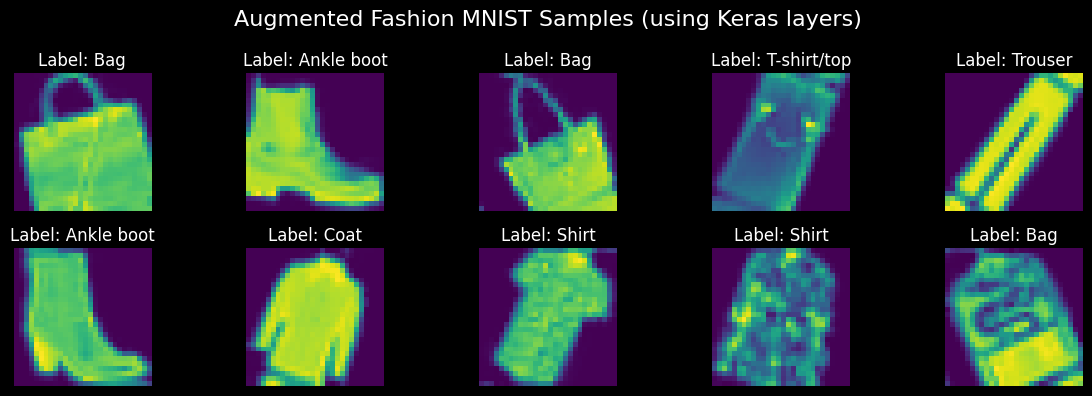

In [29]:
# Visualize augmented data
plt.figure(figsize=(12, 4))
# Apply augmentation to a batch of training images for visualization
augmented_images = data_augmentation(train_images_cnn[:10], training=True)

for i in range(10):
    # Use the augmented images for visualization
    image = augmented_images[i].numpy().squeeze()  # remove channel dimension and get numpy array
    label = train_labels[i]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[label]}")
    plt.axis('off')
plt.suptitle("Augmented Fashion MNIST Samples (using Keras layers)", fontsize=16)
plt.tight_layout()
plt.show()

This cell defines a function `build_ann` to create a baseline Artificial Neural Network (ANN) model. The model consists of several dense layers with ReLU activation and dropout layers for regularization. It is compiled with the Adam optimizer and sparse categorical crossentropy loss. The summary of the model architecture is then printed.

This cell also trains the baseline ANN model using the flattened training images and their corresponding labels. It uses the validation set to monitor performance during training and trains for 15 epochs with a batch size of 128. The training history is stored in the `ann_history` variable.

In [30]:
from tensorflow.keras import layers, models, optimizers

def build_ann(input_shape=(28*28,), num_classes=10):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

ann = build_ann()
ann.summary()

ann_history = ann.fit(train_images_ann, train_labels, validation_data=(validation_images_ann, validation_labels), epochs=15, batch_size=128)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7150 - loss: 0.7901 - val_accuracy: 0.8532 - val_loss: 0.3998
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8385 - loss: 0.4386 - val_accuracy: 0.8745 - val_loss: 0.3502
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8601 - loss: 0.3817 - val_accuracy: 0.8740 - val_loss: 0.3391
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8686 - loss: 0.3570 - val_accuracy: 0.8837 - val_loss: 0.3146
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8711 - loss: 0.3485 - val_accuracy: 0.8817 - val_loss: 0.3174
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8775 - loss: 0.3341 - val_accuracy: 0.8818 - val_loss: 0.3293
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8791 - loss: 0.3219 - val_accuracy: 0.8843 - val_loss: 0.3055
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8832 - loss: 0.3110 - val_accuracy: 0.

This cell evaluates the trained baseline ANN model on the test dataset. It prints the test loss and test accuracy to give an indication of the model's performance on unseen data.

In [31]:
ann_eval = ann.evaluate(test_images_ann, test_labels, verbose=0)
print(f'ANN Test loss: {ann_eval[0]:.4f}, Test accuracy: {ann_eval[1]:.4f}')

ANN Test loss: 0.3245, Test accuracy: 0.8846


This cell defines a function `build_cnn` to create a baseline Convolutional Neural Network (CNN) model. The model includes convolutional layers, max pooling layers, a flatten layer, dense layers, and a dropout layer. It also incorporates the previously defined `data_augmentation` layer at the beginning of the model. The model is compiled with the Adam optimizer and sparse categorical crossentropy loss. The summary of the model architecture is then printed.

This cell also trains the baseline CNN model using the reshaped training images and their corresponding labels. It uses the validation set to monitor performance during training and trains for 15 epochs with a batch size of 128. The training history is stored in the `cnn_history` variable.

In [32]:
def build_cnn(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn = build_cnn()
cnn.summary()

cnn_history = cnn.fit(train_images_cnn, train_labels, validation_data=(validation_images_cnn, validation_labels), epochs=15, batch_size=128)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5751 - loss: 1.1599 - val_accuracy: 0.7608 - val_loss: 0.6175
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7662 - loss: 0.6339 - val_accuracy: 0.8183 - val_loss: 0.4870
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7901 - loss: 0.5696 - val_accuracy: 0.8297 - val_loss: 0.4636
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8053 - loss: 0.5265 - val_accuracy: 0.8503 - val_loss: 0.4050
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8180 - loss: 0.5009 - val_accuracy: 0.8562 - val_loss: 0.3845
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8311 - loss: 0.4661 - val_accuracy: 0.8330 - val_loss: 0.4515
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8349 - loss: 0.4451 - val_accuracy: 0.8642 - val_loss: 0.3718
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8428 - loss: 0.4317 - val_accuracy: 0

This cell evaluates the trained baseline CNN model on the test dataset. It prints the test loss and test accuracy to give an indication of the model's performance on unseen data.

In [33]:
cnn_eval = cnn.evaluate(test_images_cnn, test_labels, verbose=0)
print(f'CNN Test loss: {cnn_eval[0]:.4f}, Test accuracy: {cnn_eval[1]:.4f}')

CNN Test loss: 0.3717, Test accuracy: 0.8664


This cell defines a function `plot_histories` to visualize the training history of the models. It plots the training and validation loss and accuracy curves for both models on the same graph, allowing for a visual comparison of their learning progress. The plot uses a dark background style for better contrast.

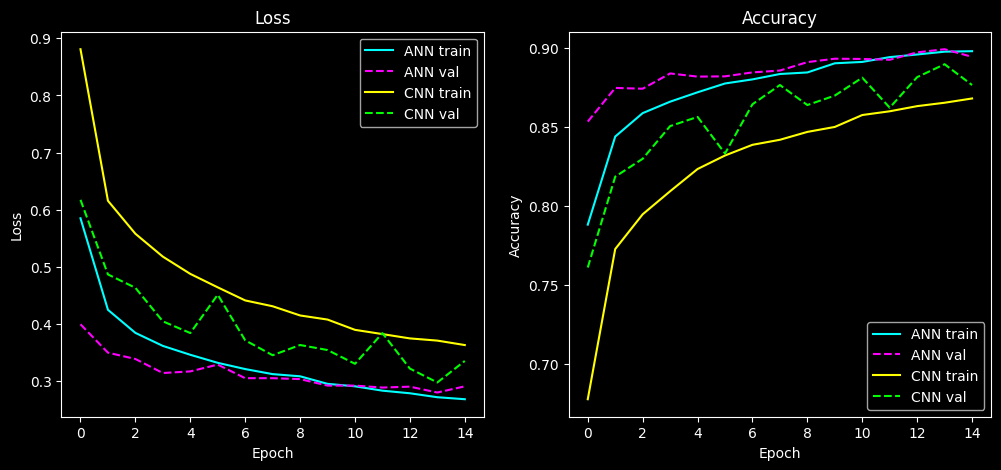

In [34]:
def plot_histories(h1, h2, label1='ANN', label2='CNN'):
    plt.style.use('dark_background') # Use a dark grid style
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(h1.history['loss'], label=f'{label1} train', color='cyan') # More colorful lines
    plt.plot(h1.history['val_loss'], '--', label=f'{label1} val', color='magenta')
    plt.plot(h2.history['loss'], label=f'{label2} train', color='yellow')
    plt.plot(h2.history['val_loss'], '--', label=f'{label2} val', color='lime')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h1.history['accuracy'], label=f'{label1} train', color='cyan') # More colorful lines
    plt.plot(h1.history['val_accuracy'], '--', label=f'{label1} val', color='magenta')
    plt.plot(h2.history['accuracy'], label=f'{label2} train', color='yellow')
    plt.plot(h2.history['val_accuracy'], '--', label=f'{label2} val', color='lime')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_histories(ann_history, cnn_history)

This cell generates predictions on the test set for both the baseline ANN and CNN models. It then calculates and plots the confusion matrices for each model, showing how many samples were correctly and incorrectly classified for each class. Finally, it prints the classification reports, which provide detailed metrics like precision, recall, and F1-score for each class.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


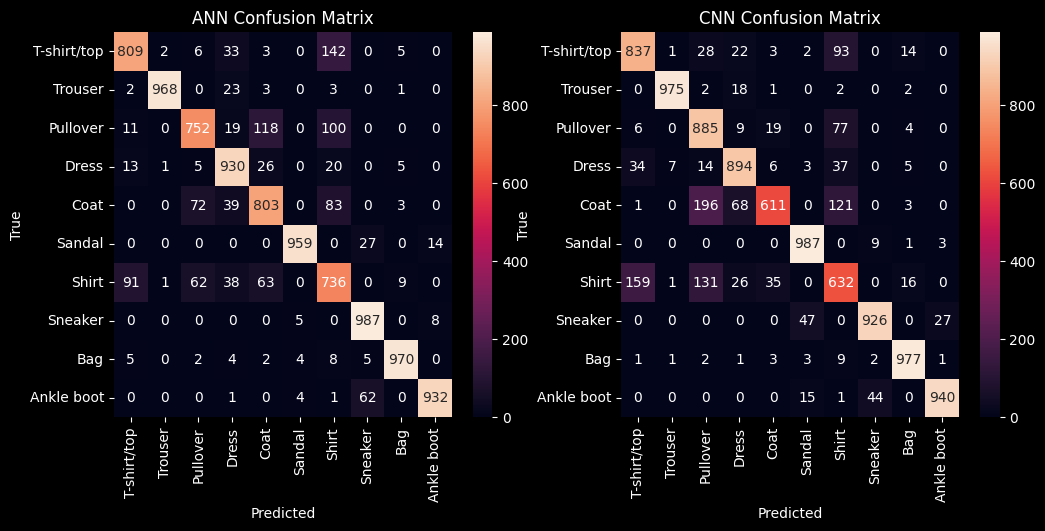


Classification report — CNN:

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.84      0.82      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.70      0.89      0.78      1000
       Dress       0.86      0.89      0.88      1000
        Coat       0.90      0.61      0.73      1000
      Sandal       0.93      0.99      0.96      1000
       Shirt       0.65      0.63      0.64      1000
     Sneaker       0.94      0.93      0.93      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.97      0.94      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.87      0.86     10000


Classification report — ANN:

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.81      0.84      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover    

In [35]:
cnn_test_predictions = np.argmax(cnn.predict(test_images_cnn), axis=1)
ann_test_predictions = np.argmax(ann.predict(test_images_ann), axis=1)

cm_cnn = confusion_matrix(test_labels, cnn_test_predictions)
cm_ann = confusion_matrix(test_labels, ann_test_predictions)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_ann, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('ANN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_cnn, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('\nClassification report — CNN:\n')
print(classification_report(test_labels, cnn_test_predictions, target_names=class_names))
print('\nClassification report — ANN:\n')
print(classification_report(test_labels, ann_test_predictions, target_names=class_names))

Models use `EarlyStopping` and `ReduceLROnPlateau` callbacks to prevent overfitting and adjust the learning rate during training. The model is trained for up to 40 epochs with a batch size of 128. After training, it evaluates the model on the test set and prints the test loss and accuracy, along with train and test accuracies.

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Early stopping and learning rate scheduler
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

This cell defines a function `build_ann_improved` to create an improved ANN model. This version increases the number of units in the dense layers and includes Batch Normalization and Dropout layers for better regularization. The model is compiled with the Nadam optimizer and a learning rate of 1e-3. The summary of the improved ANN model architecture is then printed, followed by the training of the model and evaluation on the test set.

In [37]:
from tensorflow.keras import Input

def build_ann_improved(input_shape=(28*28,), num_classes=10):
  model = models.Sequential([
      Input(shape=input_shape),
      layers.Dense(1024, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.4),
      layers.Dense(512, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.4),
      layers.Dense(256, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])
  model.compile(optimizer=optimizers.Nadam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

ann_imp = build_ann_improved()
ann_imp.summary()

ann_imp_history = ann_imp.fit(train_images_ann, train_labels, validation_data=(validation_images_ann, validation_labels), epochs=30, batch_size=128, callbacks=[es, rlr])
ann_imp_eval = ann_imp.evaluate(test_images_ann, test_labels, verbose=0)
print(f'Improved ANN Test loss: {ann_imp_eval[0]:.4f}, Test accuracy: {ann_imp_eval[1]:.4f}')

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,468,682 (5.60 MB)

 Trainable params: 1,465,610 (5.59 MB)

 Non-trainable params: 3,072 (12.00 KB)

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7589 - loss: 0.6764 - val_accuracy: 0.8580 - val_loss: 0.3879 - learning_rate: 0.0010
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8360 - loss: 0.4428 - val_accuracy: 0.8603 - val_loss: 0.3742 - learning_rate: 0.0010
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8519 - loss: 0.4004 - val_accuracy: 0.8632 - val_loss: 0.3611 - learning_rate: 0.0010
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8613 - loss: 0.3728 - val_accuracy: 0.8752 - val_loss: 0.3465 - learning_rate: 0.0010
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8642 - loss: 0.3681 - val_accuracy: 0.8848 - val_loss: 0.3180 - learning_rate: 0.0010
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8674 - loss: 0.3614 - val_accuracy: 0.8798 - val_loss: 0.3215 - learning_rate: 0.0010
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8747 - loss: 0.3379 

This cell defines a function `build_cnn_improved` to create an improved CNN model. This version includes additional convolutional layers, Batch Normalization layers after each convolution, and increased filter sizes in the dense layer. These changes are intended to improve model performance. The model is compiled with the Adam optimizer and a reduced learning rate. The summary of the improved CNN model architecture is then printed.

In [38]:
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation generator
# Define the augmentation layers
aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Improved CNN with BatchNorm and more filters
def build_cnn_improved(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential([
      data_augmentation,
      layers.Conv2D(32, (3,3), padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.Conv2D(32, (3,3), padding='same', activation='relu'),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(64, (3,3), padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.Conv2D(64, (3,3), padding='same', activation='relu'),
      layers.MaxPooling2D((2,2)),

      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')

    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_imp = build_cnn_improved()
cnn_imp.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ (10, 28, 28, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (10, 28, 28, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (10, 28, 28, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (10, 28, 28, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (10, 14, 14, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (10, 14, 14, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (10, 14, 14, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (10, 14, 14, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (10, 7, 7, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (10, 3136)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (10, 256)              │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (10, 256)              │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (10, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (10, 10)               │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 872,042 (3.33 MB)

 Trainable params: 871,338 (3.32 MB)

 Non-trainable params: 704 (2.75 KB)

In [39]:
#Train improved CNN (augmentation is built into the model)
batch_size = 128
steps_per_epoch = train_images_cnn.shape[0] // batch_size

cnn_imp_history = cnn_imp.fit(
    train_images_cnn, train_labels,
    validation_data=(validation_images_cnn, validation_labels),
    epochs=40,
    batch_size=batch_size,
    callbacks=[es, rlr]
)

#Evaluate on test set
cnn_imp_eval = cnn_imp.evaluate(test_images_cnn, test_labels, verbose=0)
print(f'Improved CNN Test loss: {cnn_imp_eval[0]:.4f}, Test accuracy: {cnn_imp_eval[1]:.4f}')

test_loss, test_acc = cnn_imp.evaluate(test_images_cnn, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

train_loss, train_acc = cnn_imp.evaluate(train_images_cnn, train_labels, verbose=2)
print(f"Train accuracy: {train_acc:.4f}")

Epoch 1/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.6968 - loss: 0.8941 - val_accuracy: 0.5013 - val_loss: 1.4351 - learning_rate: 0.0010
Epoch 2/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8249 - loss: 0.4869 - val_accuracy: 0.8478 - val_loss: 0.4227 - learning_rate: 0.0010
Epoch 3/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8500 - loss: 0.4198 - val_accuracy: 0.8510 - val_loss: 0.4121 - learning_rate: 0.0010
Epoch 4/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8634 - loss: 0.3793 - val_accuracy: 0.8545 - val_loss: 0.4188 - learning_rate: 0.0010
Epoch 5/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8742 - loss: 0.3484 - val_accuracy: 0.8943 - val_loss: 0.3022 - learning_rate: 0.0010
Epoch 6/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8795 - loss: 0.3336 - val_accuracy: 0.8832 - val_loss: 0.3294 - learning_rate: 0.0010
Epoch 7/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8829 - loss: 0

This cell uses the `plot_histories` function to visualize the training and validation loss and accuracy curves for the improved ANN and improved CNN models. This allows for a direct comparison of how the improvements affected the training process and performance of both types of networks.

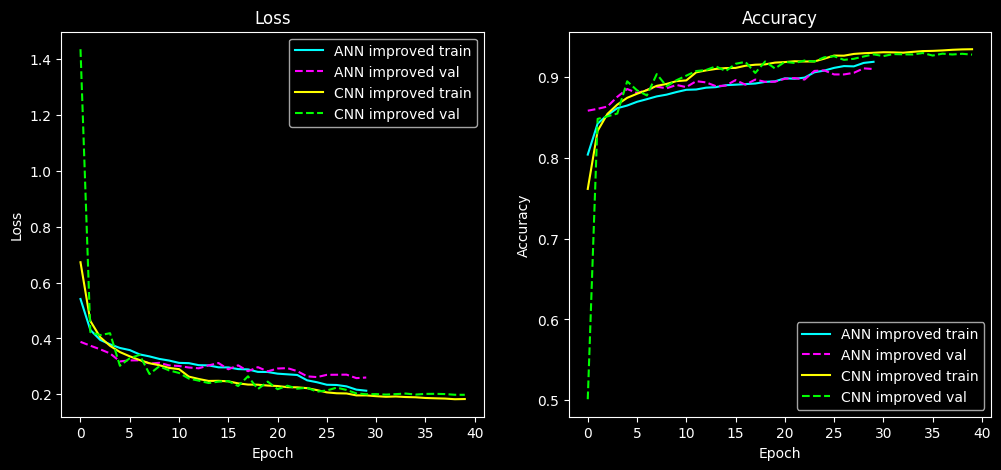

In [40]:
plot_histories(ann_imp_history, cnn_imp_history, label1='ANN improved', label2='CNN improved')

This cell calculates and plots the confusion matrices for the improved ANN and improved CNN models on the test set. It also prints the classification reports for both improved models, providing detailed performance metrics for each class. This helps to understand where each model excels and struggles in classification.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


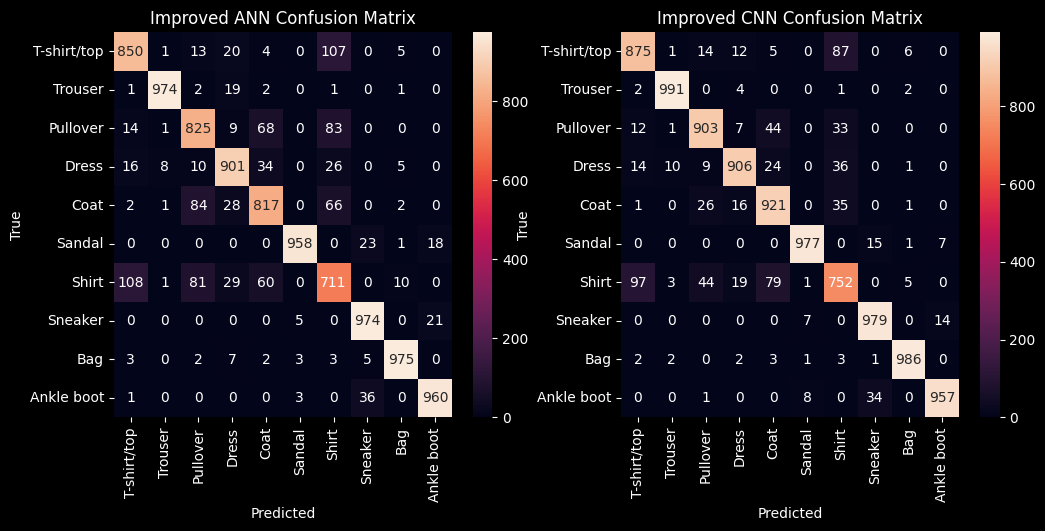


Classification report — Improved CNN:

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.88      0.87      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.91      0.90      0.90      1000
       Dress       0.94      0.91      0.92      1000
        Coat       0.86      0.92      0.89      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.79      0.75      0.77      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000


Classification report — Improved ANN:

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.85      0.85      1000
     Trouser       0.99      0.97      0.98      100

In [41]:
cnn_test_predictions = np.argmax(cnn_imp.predict(test_images_cnn), axis=1)
ann_test_predictions = np.argmax(ann_imp.predict(test_images_ann), axis=1)

cm_cnn = confusion_matrix(test_labels, cnn_test_predictions)
cm_ann = confusion_matrix(test_labels, ann_test_predictions)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_ann, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Improved ANN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_cnn, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Improved CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('\nClassification report — Improved CNN:\n')
print(classification_report(test_labels, cnn_test_predictions, target_names=class_names))
print('\nClassification report — Improved ANN:\n')
print(classification_report(test_labels, ann_test_predictions, target_names=class_names))

This cell creates a Pandas DataFrame summarizing the test loss, test accuracy, and validation accuracy for all four models trained: the baseline ANN, baseline CNN, improved ANN, and improved CNN. This table provides a clear and concise comparison of the performance metrics of each model.

In [42]:
results = {
    'model': ['ANN baseline','CNN baseline','ANN improved','CNN improved'],
    'test_loss': [ann_eval[0], cnn_eval[0], ann_imp_eval[0], cnn_imp_eval[0]],
    'test_acc': [ann_eval[1], cnn_eval[1], ann_imp_eval[1], cnn_imp_eval[1]],
    'val_acc': [ann_history.history['val_accuracy'][-1], cnn_history.history['val_accuracy'][-1], ann_imp_history.history['val_accuracy'][-1], cnn_imp_history.history['val_accuracy'][-1]]
}


import pandas as pd
res_df = pd.DataFrame(results)
res_df

,model,test_loss,test_acc,val_acc
0,ANN baseline,0.324466,0.8846,0.894167
1,CNN baseline,0.371712,0.8664,0.876333
2,ANN improved,0.297914,0.8945,0.909500
3,CNN improved,0.218876,0.9247,0.927333


###Attempt to implemend GAN model


In [43]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# Load and preprocess Fashion MNIST
# ==========================================================
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(64)

# ==========================================================
# Generator
# ==========================================================
def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])
    return model

# ==========================================================
# Discriminator (Critic)
# ==========================================================
def make_critic():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# ==========================================================
# Gradient Penalty
# ==========================================================
def gradient_penalty(critic, real, fake):
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0., 1.)
    interpolated = alpha * real + (1 - alpha) * fake
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = critic(interpolated, training=True)
    grads = gp_tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]) + 1e-12)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

# ==========================================================
# Loss functions
# ==========================================================
def critic_loss(real_output, fake_output, gp, lambda_gp=10):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + lambda_gp * gp

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

# ==========================================================
# Models and optimizers
# ==========================================================
generator = make_generator()
critic = make_critic()
gen_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
crit_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# ==========================================================
# Training step
# ==========================================================
@tf.function
def train_step(real_images):
    noise_dim = 100
    batch_size = tf.shape(real_images)[0]

    # Train critic more times than generator
    for _ in range(5):
        noise = tf.random.normal([batch_size, noise_dim])
        with tf.GradientTape() as crit_tape:
            fake_images = generator(noise, training=True)
            real_output = critic(real_images, training=True)
            fake_output = critic(fake_images, training=True)
            gp = gradient_penalty(critic, real_images, fake_images)
            crit_loss = critic_loss(real_output, fake_output, gp)
        grads = crit_tape.gradient(crit_loss, critic.trainable_variables)
        crit_opt.apply_gradients(zip(grads, critic.trainable_variables))

    # Train generator
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)
        fake_output = critic(fake_images, training=True)
        gen_loss = generator_loss(fake_output)
    grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_opt.apply_gradients(zip(grads, generator.trainable_variables))
    return gen_loss, crit_loss

# ==========================================================
# Generate and show images
# ==========================================================
def generate_images(model, test_input, epoch):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = (predictions[i, :, :, 0] + 1) / 2.0  # Convert from [-1,1] → [0,1]
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'WGAN-GP Generated Images at Epoch {epoch}')
    plt.tight_layout()
    plt.show()

# ==========================================================
# Full Training Loop
# ==========================================================
def train(dataset, epochs):
    seed = tf.random.normal([16, 100])
    for epoch in range(epochs):
        for real_images in dataset:
            gen_loss, crit_loss = train_step(real_images)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}, Gen Loss: {gen_loss:.4f}, Crit Loss: {crit_loss:.4f}")
            generate_images(generator, seed, epoch + 1)

# ==========================================================
# Run training
# ==========================================================
train(dataset, epochs=50)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 